In [1]:
from datasets import Dataset, load_dataset, features, ClassLabel, load_from_disk

import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
from itertools import chain

import networkx as nx
import community as community_louvain
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import bipartite

import seaborn as sns
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

from llm_mri import LLM_MRI

/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando os dados e dividindo classes

Top quantil: 6.0
Botton quantil: 4.0
All columns ['annotation id', 'original', 'traducao', 'organization level', 'global score', 'auto', 'label']
top: 88
botton: 104
TOTAL: 435


,text,label
0,A doença pulmonar obstrutiva crônica afeta a r...,botton
1,A doença pulmonar obstrutiva crônica dificulta...,botton
2,A doença obstrutiav pulomonar esta relacionada...,mid
3,A doença pulmonar obstrutiva crônica ou DPOC o...,botton
4,"DPOC reduz fluxo aéreo, perda da elastância, a...",botton


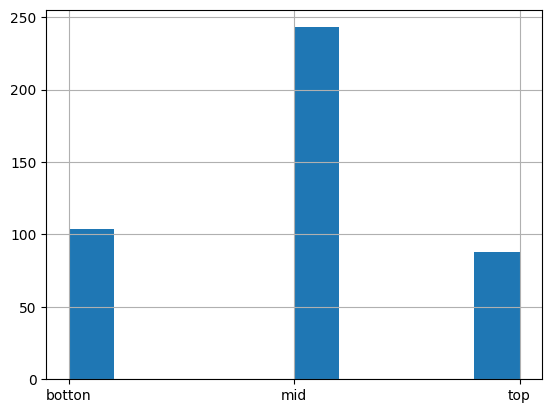

In [2]:
def label_answer(row, score, botton_quantile, top_quantile):
    if (row[score] < botton_quantile):
        return 'botton'
    elif (row[score] > top_quantile):
        return 'top'
    else:
        return 'mid'
        
# exp = "iam"
exp = "dpoc"
lang = "_pt"
# lang = "_en"
if "pt" in lang:
    text_column = 'original'
else:
    text_column = 'auto'
    
df_traducao = pd.read_csv('data/experimento_consolidado_' + exp + '.csv')

score = 'global score'#organization_level,global_score
quantile = .3

print("Top quantil:", df_traducao[score].quantile(1 - quantile))
print("Botton quantil:", df_traducao[score].quantile(quantile))

#df_traducao[score].hist()

df_traducao['label'] = df_traducao.apply(
    label_answer,
    axis=1,
    score=score,
    botton_quantile=df_traducao[score].quantile(quantile),
    top_quantile=df_traducao[score].quantile(1 - quantile),
)

columns_to_remove = list(df_traducao.columns)
print("All columns", columns_to_remove)

columns_to_remove.remove(text_column)
columns_to_remove.remove('label')

df_data = df_traducao.rename(columns={text_column: 'text'}).drop(columns=columns_to_remove).reset_index(drop=True)


df_data['label'].hist()
# df_data = df_data.drop(df_data[df_data['label'] == "mid"].index).reset_index(drop=True)
print("top:", df_data['label'].loc[df_data['label'] == "top"].count())
print("botton:", df_data['label'].loc[df_data['label'] == "botton"].count())
print("TOTAL:", df_data['label'].count())
df_data.head()


# Passando os Dados para o Módulo

- converte o Dataframe para Dataset;
- carrega o modelo e os dados no módulo;
- processa as ativações;

In [3]:
subset = Dataset.from_pandas(df_data)
subset.cleanup_cache_files()

label_feature = subset.features['label']
class_names  = subset.unique("label")

class_feature = features.ClassLabel(names=sorted(class_names))
subset = subset.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

subset = subset.cast(features.Features({
    "label": class_feature,
    "text": subset.features["text"]}))

Casting the dataset: 100%|█████████| 435/435 [00:00<00:00, 156302.77 examples/s]


# Analisando Ativações do Grafo

In [4]:
# Já foram 10:[0,1,2,3,4]
# Já foram 20:[0,1,2]

models = { 
    # "nlpie/tiny-clinicalbert": 4,          
    # "distilbert-base-uncased": 6,
    # "google-bert/bert-base-uncased": 12,
    # "emilyalsentzer/Bio_ClinicalBERT": 12,
    # "google-bert/bert-large-uncased": 24,

    "neuralmind/bert-base-portuguese-cased": 12, # 110M
    # "pucpr/biobertpt-all": 12, # 110M
    # "google-bert/bert-base-multilingual-cased": 12, # 110M
    # "neuralmind/bert-large-portuguese-cased": 24, # 330M
    
    # "openai-community/gpt2": 12,
    # "openai-community/gpt2-large": 36
    # "FacebookAI/xlm-roberta-large": 24,
    # "facebook/xlm-roberta-xl": 36,          # 3.48B

    
    # "pierreguillou/gpt2-small-portuguese": 12, # 1.5B
    # "pucpr/gpt2-bio-pt": 12, # 1.5B
}
map_dimensions = [
    # 5,
    # 10,
    25
]

for model_name, number_of_layers in models.items():
    for dimension in map_dimensions:
        print("Loading:", model_name, " - ", dimension, " - ", number_of_layers)
        llm_mri = LLM_MRI(model=model_name, device="cpu", dataset=subset)
        llm_mri.process_activation_areas(map_dimension = dimension)

        # Gera, atribui camadas e escreve o grafo top
        G_top = llm_mri.get_graph("top")
        for n in G_top.nodes:
            G_top.nodes[n]['layer'] = int(n.split("_")[0])
        nx.write_gml(G_top, 'graphs/' + exp + '_' +  model_name.split('/')[1] + '_' + str(dimension) + '_top.gml')
        print("Salvo grafo top")
            
        # Gera, atribui camadas e escreve o grafo botton
        G_botton = llm_mri.get_graph("botton")
        for n in G_botton.nodes:
            G_botton.nodes[n]['layer'] = int(n.split("_")[0])
        nx.write_gml(G_botton, 'graphs/' + exp + '_' +  model_name.split('/')[1] + '_' + str(dimension) + '_botton.gml')
        print("Salvo grafo botton")

        # Gera, atribui camadas e atribui peso normalizado por classe às arestas
        G_composed = llm_mri.get_composed_graph("top", "botton")
        for n in G_composed.nodes:
            G_composed.nodes[n]['layer'] = int(n.split("_")[0])

        label1, label2 = [0, 1]
        label1_counts = {node: 0 for node in G_composed.nodes()}
        label2_counts = {node: 0 for node in G_composed.nodes()}
        
        for u, v, data in G_composed.edges(data=True):
            label = data.get('label')
            weight = data.get('weight', 1)  # default weight is 1 if not specified
        
            if label == label1:
                label1_counts[u] += weight
                label1_counts[v] += weight
            elif label == label2:
                label2_counts[u] += weight
                label2_counts[v] += weight
            else: # label == 2
                label1_counts[u] += weight
                label1_counts[v] += weight
                label2_counts[u] += weight
                label2_counts[v] += weight
        
        # initialize Normalize object to map ratios between 0 and 1
        norm = plt.Normalize(vmin=0, vmax=1)
        
        # compute proportions and assign node colors
        node_colors = []
        for node in G_composed.nodes():
            count_label1 = label1_counts.get(node, 0)
            count_label2 = label2_counts.get(node, 0)
            total = count_label1 + count_label2
        
            if total > 0:
                ratio = count_label2 / total  # proportion of label2
            else:
                ratio = 0.5  # neutral ratio if no connected edges
        
            # normalize the ratio
            norm_ratio = norm(ratio)
            node_colors.append(norm_ratio)
            G_composed.nodes[node]['class'] = norm_ratio
        
        nx.write_gml(G_composed, 'graphs/' + exp + '_' + model_name.split('/')[1] + '_' + str(dimension) + '_composed.gml')
        print("Salvo grafo composed")


Loading: neuralmind/bert-base-portuguese-cased  -  25  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 435/435 [02:45<00:00,  2.63 examples/s]


Salvo grafo top
Salvo grafo botton
Salvo grafo composed
